In [3]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.io, cv2

# Find images path
scene_paths = glob('../Dataset_CNN/*/')
print(len(scene_paths))
# Fulfill data
X_ = []
y_ = []
Xtest_ = []
ytest_ = []

print('Loading training data')
for scene in scene_paths[0:-6]:
    print(scene)
    windows_path = glob(scene + '*')
    
    for window in windows_path[0:1]:
        images_ref_path = glob(window + '/w_*.jpg')
        NLF_path = window + '/NLF_filtered.mat'
        
        mat = scipy.io.loadmat(NLF_path)
        NLF = (mat["NLF_step_filt"][0])
        NLF[np.isnan(NLF)] = 0
        
        for img_ref in images_ref_path[0:5]:
            img = plt.imread(img_ref)
            
            X_.append(img)
            y_.append(NLF*100)

print('Loading testing data')
for scene in scene_paths[-6::]:
    print(scene)
    windows_path = glob(scene + '*')
    
    for window in windows_path[0:1]:
        images_ref_path = glob(window + '/w_*.jpg')
        NLF_path = window + '/NLF_filtered.mat'
        
        mat = scipy.io.loadmat(NLF_path)
        NLF = (mat["NLF_step_filt"][0])
        NLF[np.isnan(NLF)] = 0
            
        for img_ref in images_ref_path[0:5]:
            img = plt.imread(img_ref)
            
            Xtest_.append(img)
            ytest_.append(NLF*100)
            

32
Loading training data
../Dataset_CNN/Scene_24/
../Dataset_CNN/Scene_23/
../Dataset_CNN/Scene_15/
../Dataset_CNN/Scene_12/
../Dataset_CNN/Scene_13/
../Dataset_CNN/Scene_14/
../Dataset_CNN/Scene_22/
../Dataset_CNN/Scene_25/
../Dataset_CNN/Scene_07/
../Dataset_CNN/Scene_36/
../Dataset_CNN/Scene_09/
../Dataset_CNN/Scene_31/
../Dataset_CNN/Scene_30/
../Dataset_CNN/Scene_08/
../Dataset_CNN/Scene_06/
../Dataset_CNN/Scene_20/
../Dataset_CNN/Scene_18/
../Dataset_CNN/Scene_27/
../Dataset_CNN/Scene_11/
../Dataset_CNN/Scene_29/
../Dataset_CNN/Scene_16/
../Dataset_CNN/Scene_28/
../Dataset_CNN/Scene_17/
../Dataset_CNN/Scene_10/
../Dataset_CNN/Scene_19/
../Dataset_CNN/Scene_26/
Loading testing data
../Dataset_CNN/Scene_21/
../Dataset_CNN/Scene_32/
../Dataset_CNN/Scene_35/
../Dataset_CNN/Scene_34/
../Dataset_CNN/Scene_33/
../Dataset_CNN/Scene_05/


In [2]:
X_ = np.asarray(X_)
y_ = np.asarray(y_)

Xtest_ = np.asarray(Xtest_)
ytest_ = np.asarray(ytest_)


In [3]:
print(np.shape(X_))
print(np.shape(y_))
print()
print(np.shape(Xtest_))
print(np.shape(ytest_))

(28080, 256, 256, 3)
(28080, 192)

(5400, 256, 256, 3)
(5400, 192)


### Crear modelo

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Reshape
from keras.layers import concatenate, AveragePooling2D, Activation, BatchNormalization
from keras.models import Model
from SpatialPyramidPooling import SpatialPyramidPooling
from keras.layers import LeakyReLU
import keras
# First, define the vision modules
input_imgs = Input(shape=(256, 256, 3))

# Model
def get_model_column(ks_1, ks_2):
    x = Conv2D(64, kernel_size=(ks_1,ks_1), strides = 2, activation=None)(input_imgs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x) # pool2_a
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #out = keras.layers.ZeroPadding2D(padding=((p_, 0), (0, p_)), data_format=None)(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(x)
    out = Dense(64*3, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(x)
    return out

# Create independent models
model_a = Model(input_imgs, get_model_column(5, 3))
model_b = Model(input_imgs, get_model_column(7, 5))
model_c = Model(input_imgs, get_model_column(9, 7))


### Training

In [5]:
from keras import optimizers
from keras import losses

sgd = optimizers.SGD(lr=0.001, decay=0.0001, momentum=0.9, nesterov=True)
sgd_abc = optimizers.SGD(lr=0.0001, decay=0.0001, momentum=0.9, nesterov=True)

# compile model (abc)
#model_abc.compile(optimizer= sgd, loss='mse')
#model_abc.compile(optimizer= sgd, loss=losses.kullback_leibler_divergence)


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


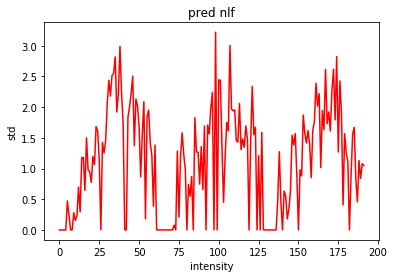

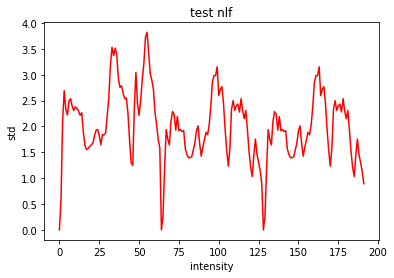

In [18]:
import matplotlib.pyplot as plt

def pred_mc_indep_net(model, ii):
    
    y_pred = np.transpose(model.predict([[X_[ii]], [X_[ii]], [X_[ii]]]))

    fig, ax = plt.subplots()
    #y_pred[y_pred < 0] = 0
    ax.plot(y_pred,'r')

    ax.set(xlabel='intensity', ylabel='std',
           title='pred nlf')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(y_[ii],'r')

    ax.set(xlabel='intensity', ylabel='std',
           title='test nlf')
    plt.show()
    
def train_indep_model(model, X_, y_, Xtest_, ytest_):
    # Variables for convergence checking
    converged = False

    print()
    std_thold = 0.001
    
    count = 0
    hist_loss = []
    hist_val_loss = []

    while not converged:

        print('Iteration ' + str(count+1))

        # Training the model
        history = model.fit(x=X_, y=y_, validation_data=(Xtest_, ytest_), 
                                epochs=1, shuffle=True, batch_size = 64)

        pred_mc_indep_net(model, 0)

        count += 1
        mean_samples = 6

        # Checking the convergence of the model using the standard deviation of the accuracy for some epochs
        hist_loss.extend(history.history["loss"])
        hist_val_loss.extend(history.history["val_loss"])    

        used_hist_val_loss = hist_val_loss[max(0,len(hist_val_loss)-mean_samples):len(hist_val_loss)]

        if len(used_hist_val_loss) >= mean_samples:
            mean_acc = float(sum(np.asarray(used_hist_val_loss)))/float(len(used_hist_val_loss))
            std_cutre = float(sum(np.abs(np.asarray(used_hist_val_loss)-mean_acc)))/float(len(used_hist_val_loss))

            print("STD OF " + str(len(used_hist_val_loss)) + ' SAMPLES: '),
            print(std_cutre)

            if std_cutre < std_thold or count > 20:
                converged = True
                return model, hist_loss, hist_val_loss


        else:
            # converged = True # Useful for testing
            print("Not enough samples to compute the STD :(")

        print('\n')
        
        

In [ ]:
model_a.summary()

In [ ]:
# Train model A
print('Model A')
'''model_a.compile(optimizer= sgd_a, loss='mse')
model_a, hist_loss_a, hist_val_loss_a = train_indep_model(model_a, X_, y_, Xtest_, ytest_)
# Train model B
print('Model B')
model_b.compile(optimizer= sgd_b, loss='mse')
model_b, hist_loss_b, hist_val_loss_b = train_indep_model(model_b, X_, y_, Xtest_, ytest_)'''
# Train model C
print('Model C')
model_c.compile(optimizer= sgd_c, loss='mse')
model_c, hist_loss_c, hist_val_loss_c = train_indep_model(model_c, X_, y_, Xtest_, ytest_)

In [ ]:
# serialize model to JSON
model_json = model_a.to_json()
with open("models/model_a_0405.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_a.save_weights("models/model_a_0405.h5")
print("Saved model to disk")

# serialize model to JSON
model_json = model_b.to_json()
with open("models/model_b_0405.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_b.save_weights("models/model_b_0405.h5")
print("Saved model to disk")

# serialize model to JSON
model_json = model_c.to_json()
with open("models/model_c_0405.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_c.save_weights("models/model_c_0405.h5")
print("Saved model to disk")

In [6]:
from keras.models import model_from_json
# load model
json_file = open("models/model_a_0405.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model_a = model_from_json(loaded_model_json)

model_a.load_weights("models/model_a_0405.h5")
print('loaded model')

loaded model


In [7]:
from keras.models import model_from_json
# load model
json_file = open("models/model_b_0405.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model_b = model_from_json(loaded_model_json)

model_b.load_weights("models/model_b_0405.h5")
print('loaded model')

loaded model


In [8]:
from keras.models import model_from_json
# load model
json_file = open("models/model_c_0405.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model_c = model_from_json(loaded_model_json)

model_c.load_weights("models/model_c_0405.h5")
print('loaded model')

loaded model


In [9]:
model_a.layers.pop()
model_a.layers.pop()
model_b.layers.pop()
model_b.layers.pop()
model_c.layers.pop()
model_c.layers.pop()

In [5]:
model_a.summary()
model_b.summary()
model_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 64)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
__________

In [10]:
from keras.layers import Input, concatenate, Dense
from keras.models import Model

# Then define the input-apart model
input_a = Input(shape=(256, 256, 3))
input_b = Input(shape=(256, 256, 3)) 
input_c = Input(shape=(256, 256, 3)) 

# The vision model will be shared, weights and all
out_a = model_a(input_a)
out_b = model_b(input_b)
out_c = model_c(input_c)

concatenated = concatenate([out_a, out_b, out_c],axis=1)
merge_abc = Dense(2048, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(concatenated)
merge_abc = Dense(64*3, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(merge_abc)
model_abc = Model([input_a, input_b, input_c], merge_abc)

In [11]:
model_abc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 192)          116672      input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (M


Iteration 1
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 87s 3ms/step - loss: 1.3424 - val_loss: 0.5270


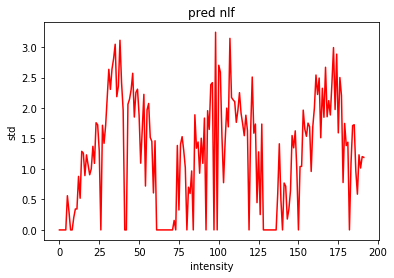

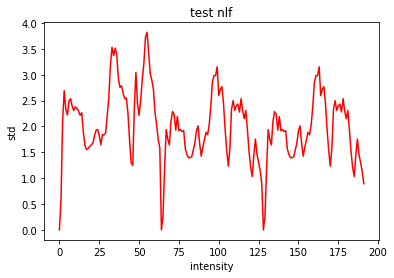

Not enough samples to compute the STD :(


Iteration 2
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.2760 - val_loss: 0.5132


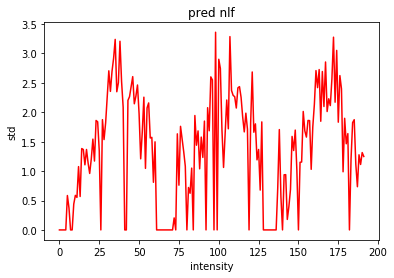

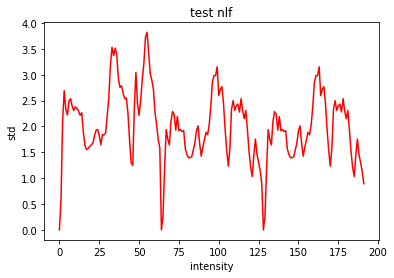

Not enough samples to compute the STD :(


Iteration 3
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.2303 - val_loss: 0.4950


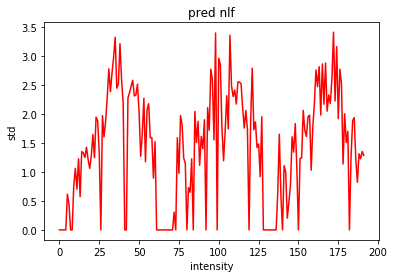

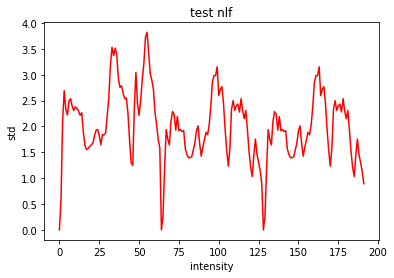

Not enough samples to compute the STD :(


Iteration 4
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.1982 - val_loss: 0.5008


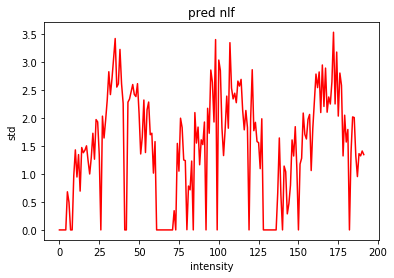

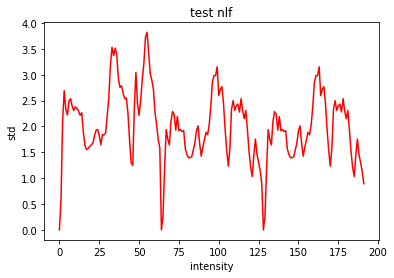

Not enough samples to compute the STD :(


Iteration 5
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.1737 - val_loss: 0.4827


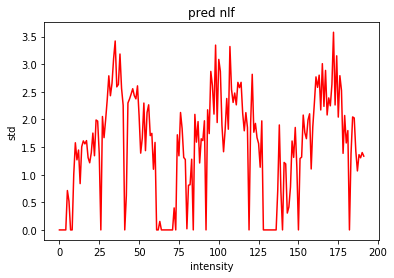

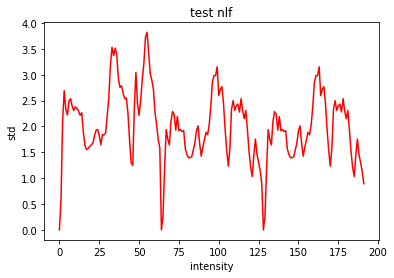

Not enough samples to compute the STD :(


Iteration 6
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.1454 - val_loss: 0.4940


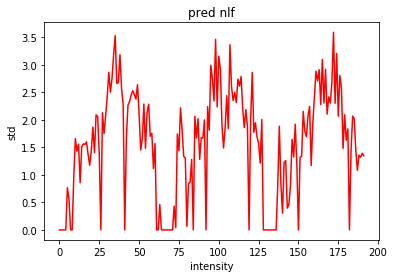

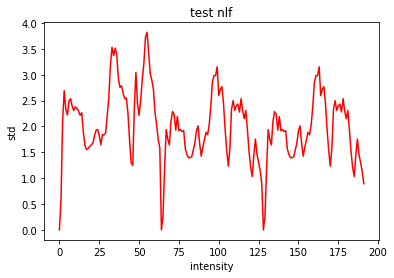

STD OF 6 SAMPLES: 
0.011993825960551763


Iteration 7
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.1208 - val_loss: 0.4898


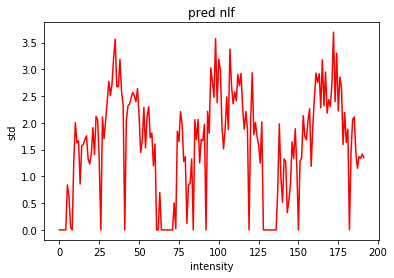

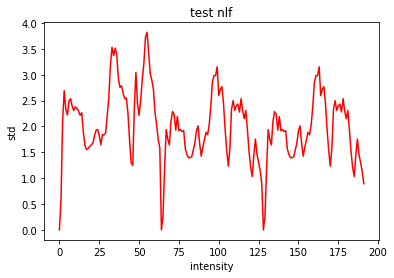

STD OF 6 SAMPLES: 
0.007379194554478052


Iteration 8
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.1031 - val_loss: 0.4877


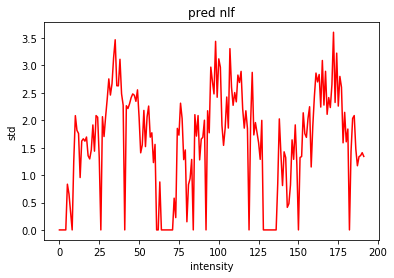

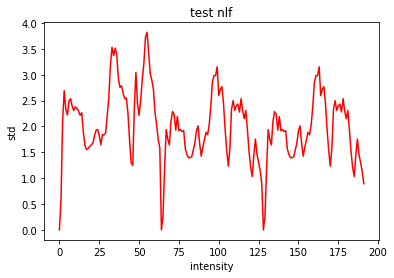

STD OF 6 SAMPLES: 
0.004916930228103827


Iteration 9
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.0773 - val_loss: 0.5039


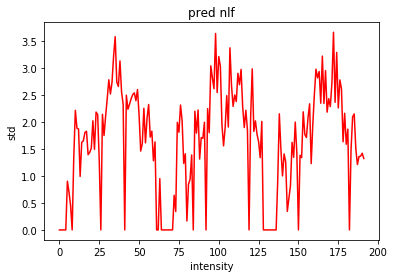

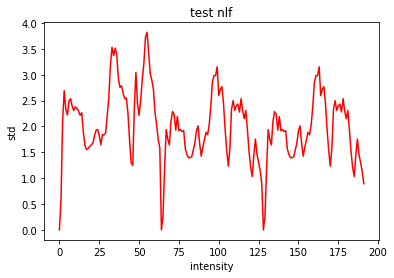

STD OF 6 SAMPLES: 
0.006399908746466232


Iteration 10
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.0565 - val_loss: 0.4939


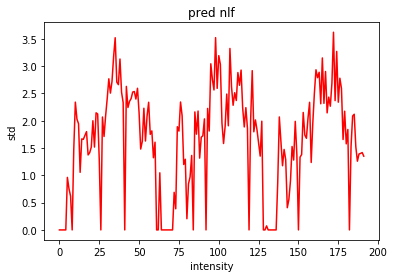

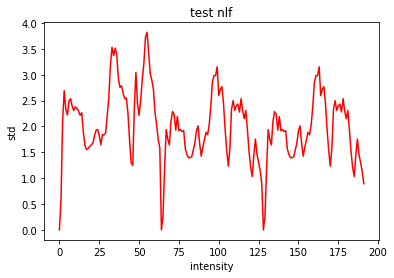

STD OF 6 SAMPLES: 
0.005251423127857258


Iteration 11
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 86s 3ms/step - loss: 1.0281 - val_loss: 0.4914


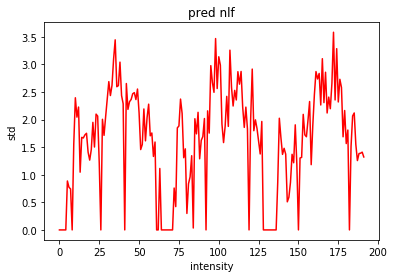

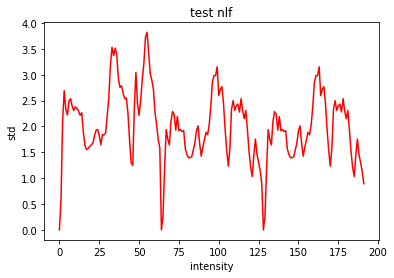

STD OF 6 SAMPLES: 
0.0037919795145223236


Iteration 12
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 86s 3ms/step - loss: 1.0078 - val_loss: 0.5121


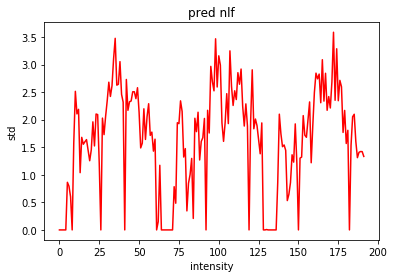

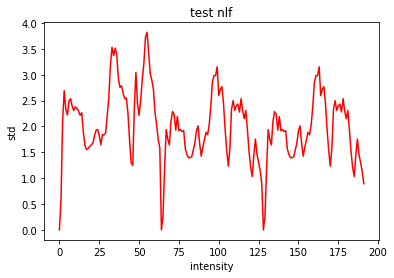

STD OF 6 SAMPLES: 
0.007678687562667781


Iteration 13
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 85s 3ms/step - loss: 1.0017 - val_loss: 0.4928


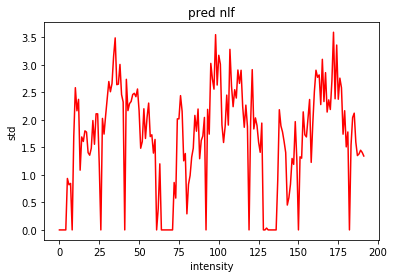

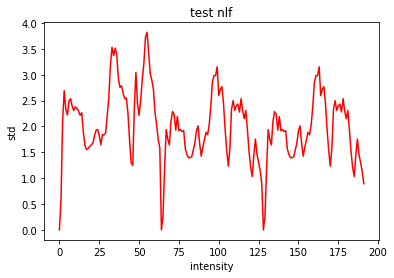

STD OF 6 SAMPLES: 
0.007345784907478337


Iteration 14
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 0.9917 - val_loss: 0.4965


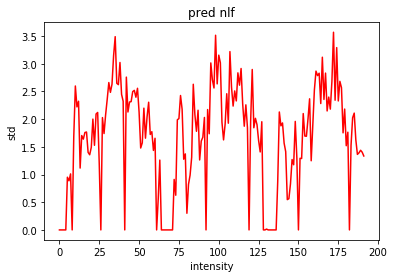

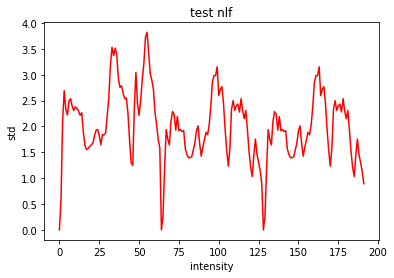

STD OF 6 SAMPLES: 
0.006368050715069721


Iteration 15
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 0.9832 - val_loss: 0.5062


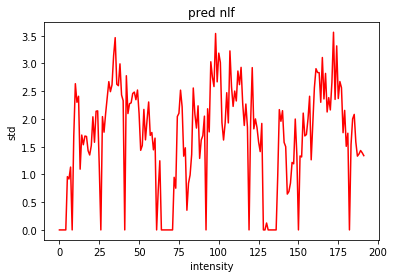

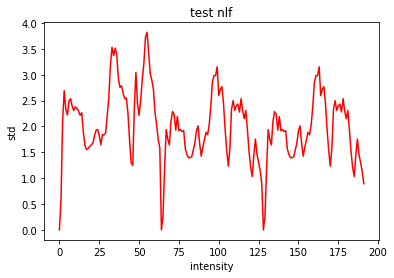

STD OF 6 SAMPLES: 
0.006874534443572722


Iteration 16
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 0.9782 - val_loss: 0.5021


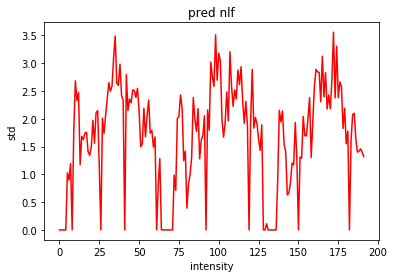

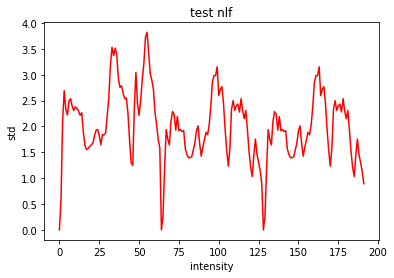

STD OF 6 SAMPLES: 
0.00658982187877466


Iteration 17
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 0.9744 - val_loss: 0.5019


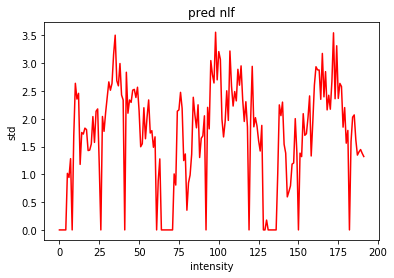

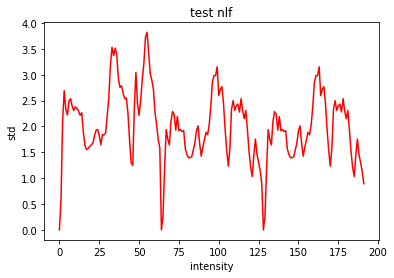

STD OF 6 SAMPLES: 
0.004840951704194028


Iteration 18
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 85s 3ms/step - loss: 0.9705 - val_loss: 0.5006


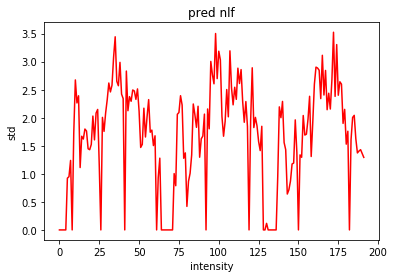

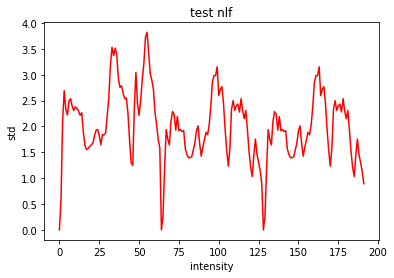

STD OF 6 SAMPLES: 
0.003561543407754155


Iteration 19
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 0.9648 - val_loss: 0.4923


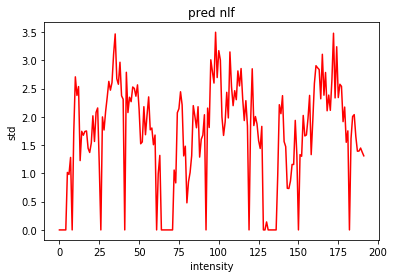

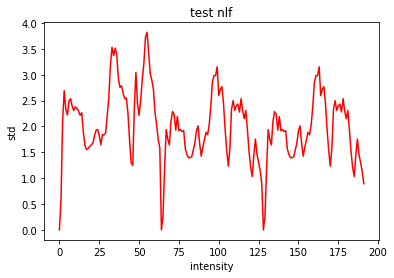

STD OF 6 SAMPLES: 
0.00367506446171198


Iteration 20
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 0.9629 - val_loss: 0.4954


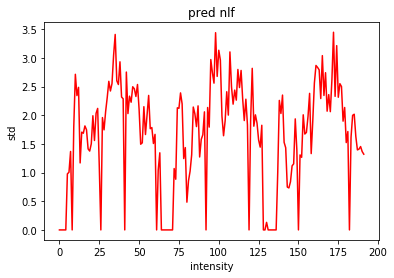

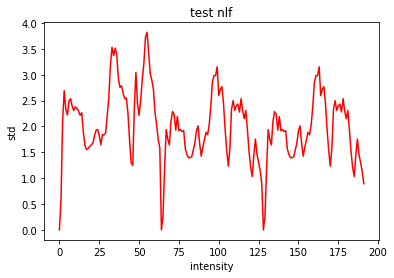

STD OF 6 SAMPLES: 
0.003916836383411439


Iteration 21
Train on 28080 samples, validate on 5400 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 0.9586 - val_loss: 0.4984


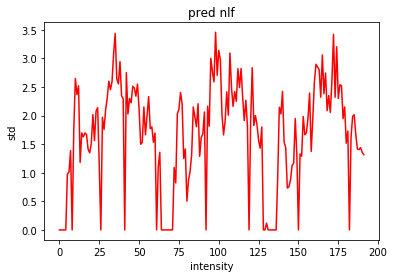

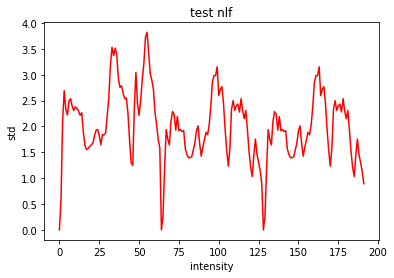

STD OF 6 SAMPLES: 
0.003063879060892394


In [19]:
# Train model ABC
model_abc.compile(optimizer= sgd_abc, loss='mse')
model_abc, hist_loss_abc, hist_val_loss_abc = train_indep_model(model_abc, [X_,X_,X_], y_, 
                                                                [Xtest_,Xtest_,Xtest_], ytest_)

In [23]:
# serialize model to JSON
model_abc.summary()
model_json = model_abc.to_json()
with open("models/model_abc_0405.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_abc.save_weights("models/model_abc_0405.h5")
print("Saved model to disk")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 192)          116672      input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (M

In [ ]:
import matplotlib.pyplot as plt
ii = 27

y_pred = np.transpose(model_abc.predict([[X_[ii]],[X_[ii]],[X_[ii]]]))

fig, ax = plt.subplots()
#y_pred[y_pred < 0] = 0
ax.plot(y_pred,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='pred nlf')
plt.show()

fig, ax = plt.subplots()
ax.plot(y_[ii],'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.utils import plot_model

plot_model(model_abc, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import scipy.io


scene = 'Scene_21'
nlf_path = '../Dataset_Final/NLFs/NLF_' + scene + '.mat'
mat = scipy.io.loadmat('../Dataset_Final/NLFs/NLF_' + scene + '.mat')
NLF = mat["NLF"][0]
NLF_r = np.nan_to_num(NLF[0:256])

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y,b,a

order = 5
fs = 30    # sample rate, Hz
cutoff = 2
y,b,a = butter_lowpass_filter(NLF_r, cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)

plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

fig, ax = plt.subplots()
ax.plot(y,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf filtered')
plt.show()

fig, ax = plt.subplots()
ax.plot(NLF_r,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf')
plt.show()